# FM-223: Lista 2

Aluno: Vinícius Freitas de Almeida

## Exercício 1

Implementar o mapa de Hénon e reproduzir as Figuras 2.3, 2.16 e 2.17 do livro.

### Mapa de Hénon

O mapa de Hénon é a função parametrizada pelas constantes reais $a,b$ dada por $$  f: \mathbb{R}^2 \mapsto \mathbb{R}^2 \\ f(x,y) = (a - x^2 + by, x)$$

Para reproduzir a figura 2.3, é preciso iterar o mapa de Hénon para $a=1.28$, $b=-0.3$ e $a=1.4$, $b=-0.3$. Além disso, é preciso variar as condições iniciais 
$(x_0,y_0)$ no domínio quadrado $[-2.5,2.5]\times[-2.5,2.5]$.

Nesta implementação em particular, a iteração do mapa de Hénon é feita $n$ vezes por meio de um código em C compilado como a biblioteca dinâmica `libhenon.so`, que é carregada pelo Python por meio do módulo `ctypes`. Para compilar o código em C, basta executar a Makefile na pasta `lib` por meio do comando `make` no terminal.

In [21]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the libhenon shared library
libhenon = ctypes.CDLL('./lib/libhenon.so') 

# Define the function signature
libhenon.iterated_henon_map.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_float, ctypes.c_float, ctypes.c_int]
libhenon.iterated_henon_map.restype = ctypes.c_float

def new_vec_i_henon_map(a, b):
    # Defines a Python function that wraps the C function
    # parameterized by a, b
    fn = lambda x,y: libhenon.iterated_henon_map(a, b, x, y, 1000)
    # vectorize with numpy
    return np.vectorize(fn)

In [22]:
# Create a 2D grid of 700x700 points
# (x,y) in [-2.5, 2.5] x [-2.5, 2.5]
x = np.linspace(-2.5, 2.5, 700)
y = np.linspace(-2.5, 2.5, 700)
X, Y = np.meshgrid(x, y)
# left plot
f = new_vec_i_henon_map(1.28, -0.3)
Z0 = f(X, Y)
# right plot
g = new_vec_i_henon_map(1.4, -0.3)
Z1 = g(X, Y)

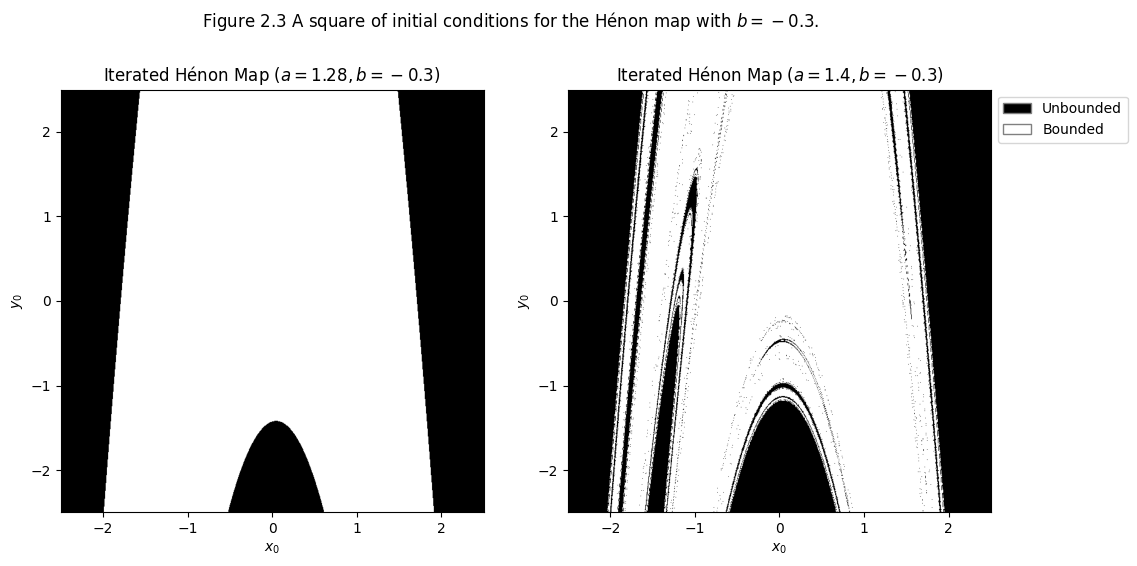

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot
ax = axs[0]
ax.imshow(Z0, origin='lower', cmap='gray_r', extent=[x.min(), x.max(), y.min(), y.max()])
ax.set_facecolor('black') # black background
ax.set_xlabel('$x_0$')
ax.set_ylabel('$y_0$')
ax.set_title('Iterated Hénon Map ($a=1.28, b=-0.3$)')

# Second plot
ax = axs[1]
ax.imshow(Z1, origin='lower', cmap='gray_r', extent=[x.min(), x.max(), y.min(), y.max()])
ax.set_facecolor('black') # black background
ax.set_xlabel('$x_0$')
ax.set_ylabel('$y_0$')
ax.set_title('Iterated Hénon Map ($a=1.4, b=-0.3$)')

# legend
unbounded_patch = mpatches.Patch(facecolor='black', label='Unbounded', edgecolor='gray')
bounded_patch = mpatches.Patch(facecolor='white', label='Bounded', edgecolor='gray')
leg = ax.legend(handles=[unbounded_patch, bounded_patch], loc='upper left', bbox_to_anchor=(1, 1))

# figure title
fig.suptitle('Figure 2.3 A square of initial conditions for the Hénon map with $b = -0.3$.')

plt.show()

### Diagrama de bifurcação do mapa de Hénon

/tmp/ipykernel_3961/1345612448.py:20: RuntimeWarning: overflow encountered in multiply
  x_ = range_a - x * x + b * y
/tmp/ipykernel_3961/1345612448.py:25: RuntimeWarning: overflow encountered in multiply
  x_ = range_a - x * x + b * y


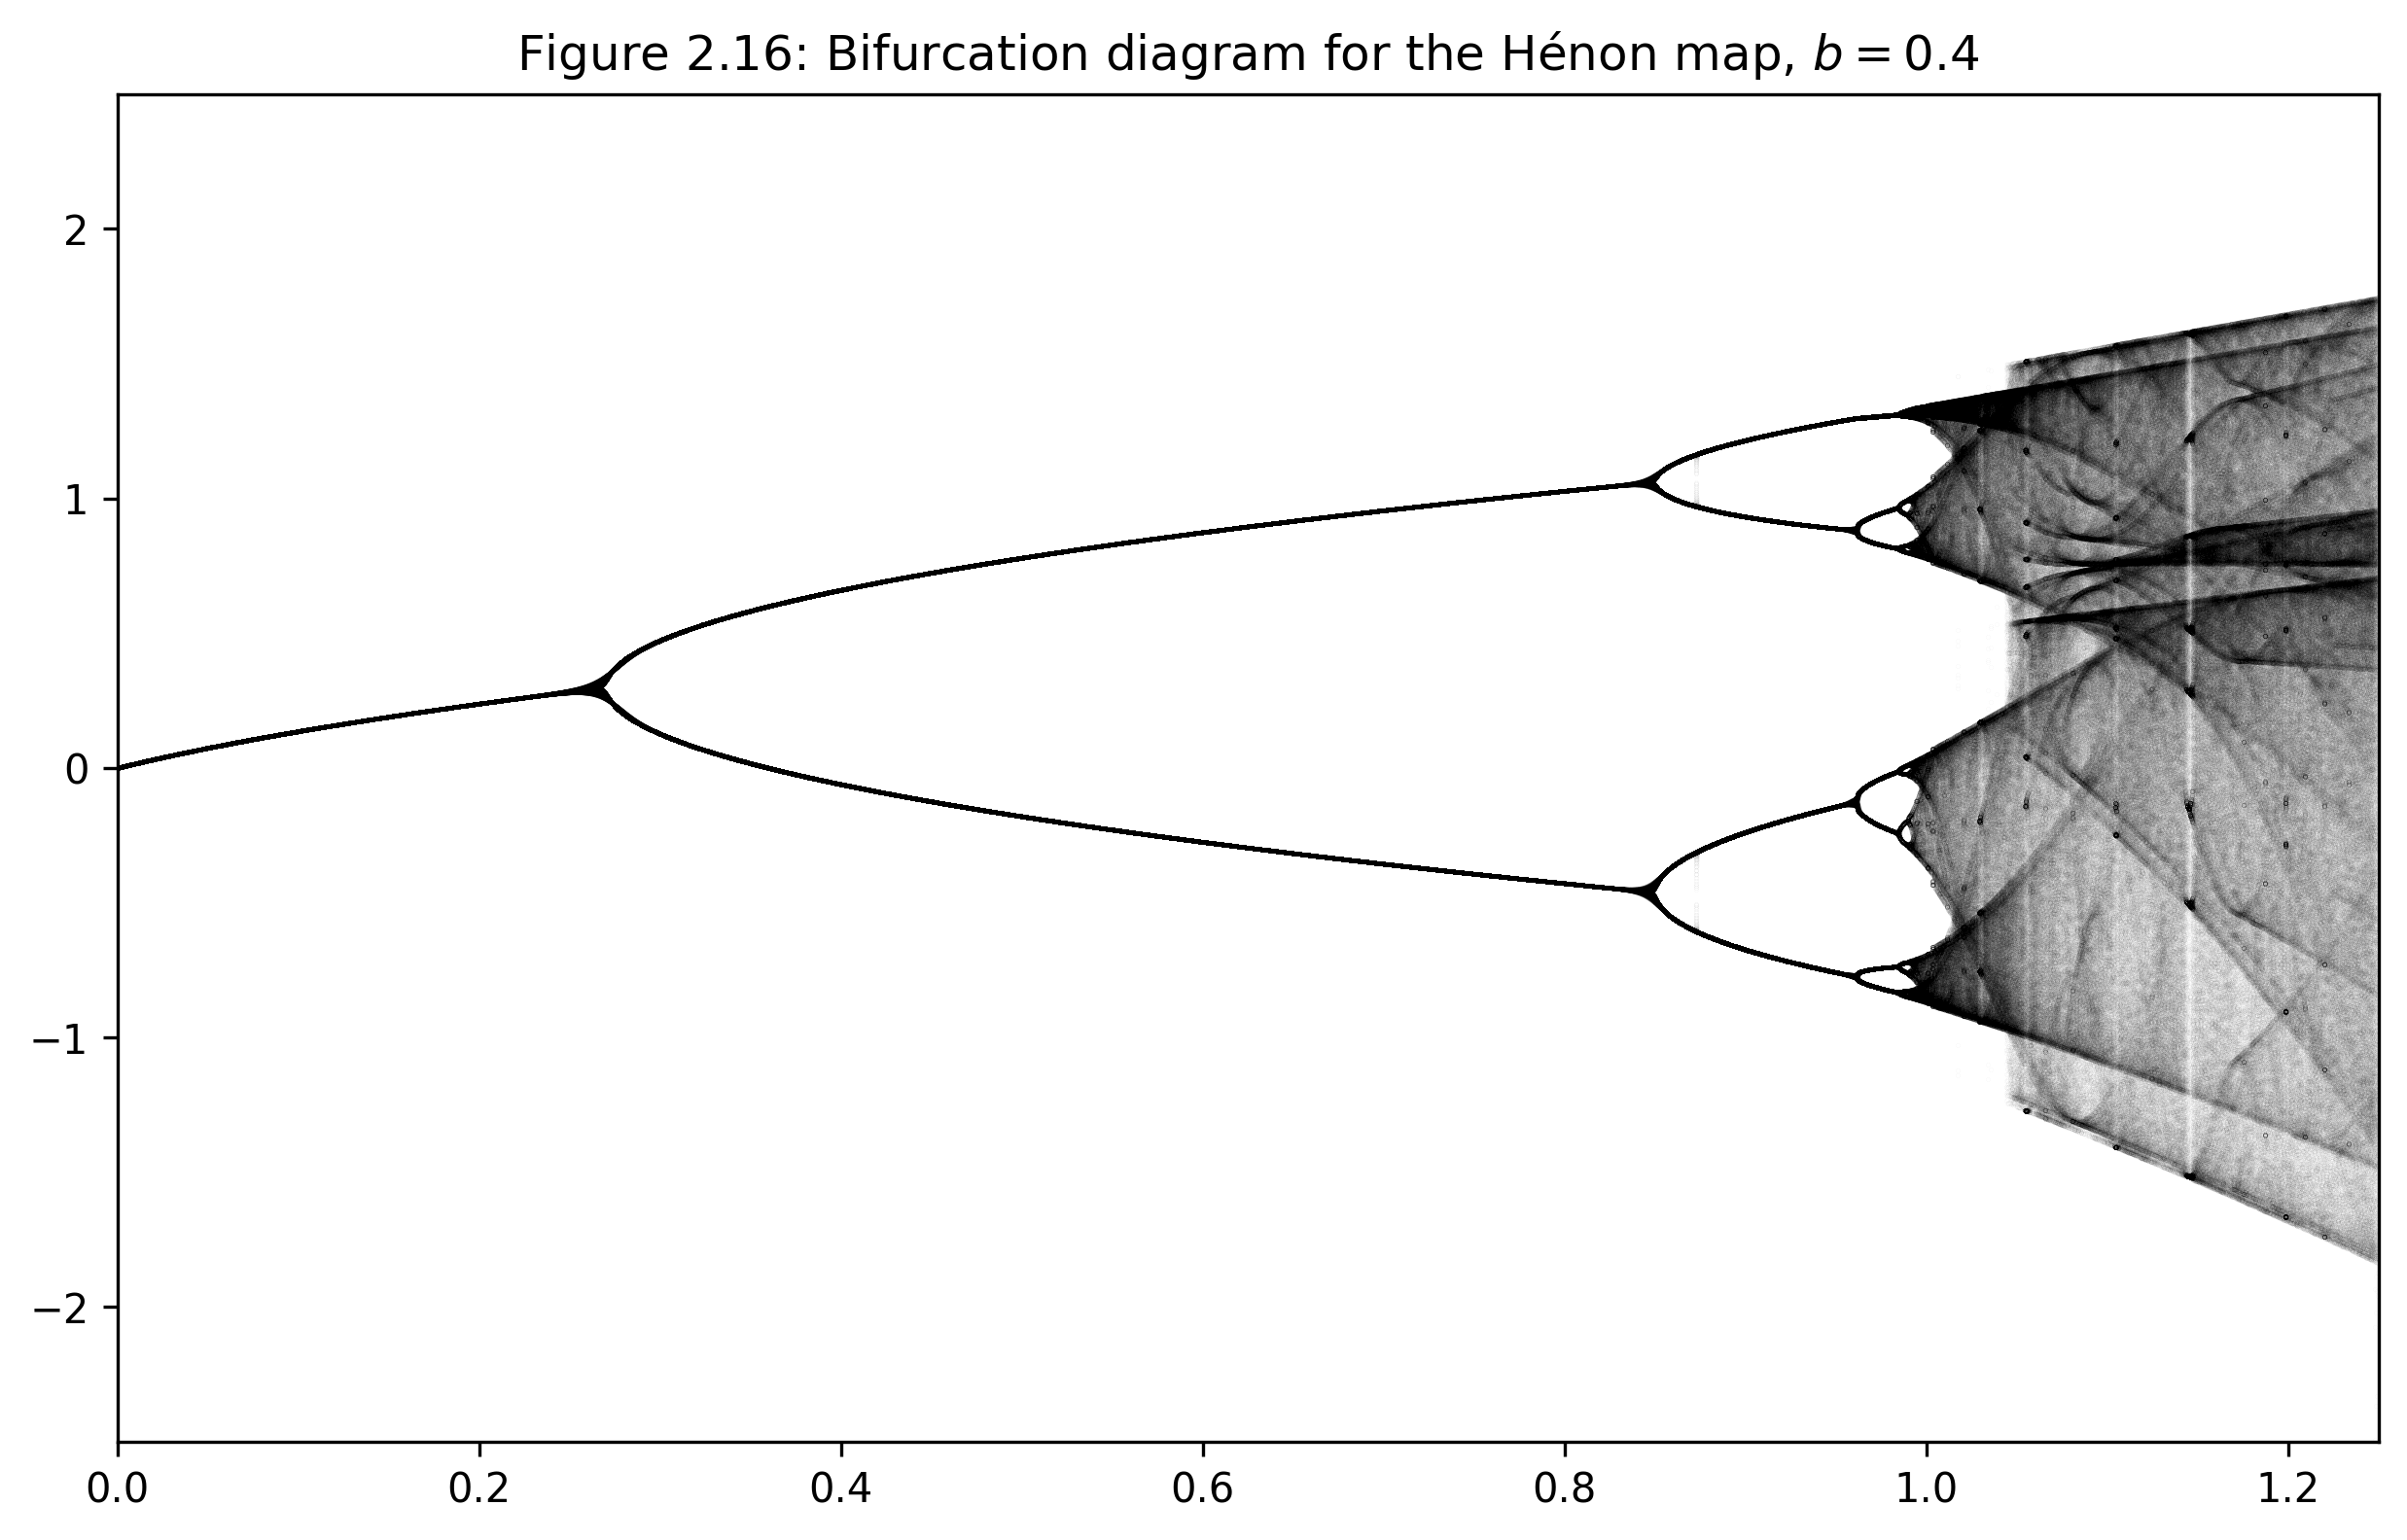

In [24]:
num_iterations = 500
dx = 1e-4
range_a = np.arange(0, 1.25, dx)
len_range = len(range_a)
num_points = num_iterations * len_range

# Preallocate arrays
av = np.empty(num_points)
xv = np.empty(num_points)

# range of x's for vectorized computation
x = np.zeros(len_range)
x_ = np.zeros(len_range)
y = np.zeros(len_range)

# fixed b
b = 0.4

for _ in range(100):  # Discard the first 100 iterates
    x_ = range_a - x * x + b * y
    np.copyto(y, x)
    np.copyto(x, x_)

for i in range(0, num_points, len_range):
    x_ = range_a - x * x + b * y
    np.copyto(y, x)
    np.copyto(x, x_)
    av[i:i+len_range] = range_a
    xv[i:i+len_range] = x

# Plotting
fig = plt.figure(figsize=(10, 6))
# high figure resolution
fig.dpi = 300


# filter xv to only x's such that |x| <= 2.5
av = av[np.where(np.abs(xv) <= 2.5)]
xv = xv[np.where(np.abs(xv) <= 2.5)]

plt.scatter(av, xv, s=0.0001, c='black', marker='.')
plt.xlim(av.min(), av.max())
plt.ylim(-2.5, 2.5)
plt.title('Figure 2.16: Bifurcation diagram for the Hénon map, $b = 0.4$')
plt.show()

### Atratores do mapa de Hénon

In [25]:
def plot_henon_attractor(ax, a, plus=True):
    n = 10000
    cutoff = 500
    b = 0.4
    x = np.zeros(n)
    y = np.zeros(n)
    for i in range(n-1):
        x[i+1] = a - x[i] * x[i] + b * y[i]
        y[i+1] = x[i]

    x = x[cutoff:]
    y = y[cutoff:]

    # filter x to only x's such that |x| <= 2.5
    ids = np.where(np.abs(x) <= 2.5)
    y = y[ids]
    x = x[ids]

    if plus:
        ax.scatter(x, y, s=100, c='black', marker='+')
    else:
        ax.scatter(x, y, s=1, c='black', marker='.')

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect(1.0)

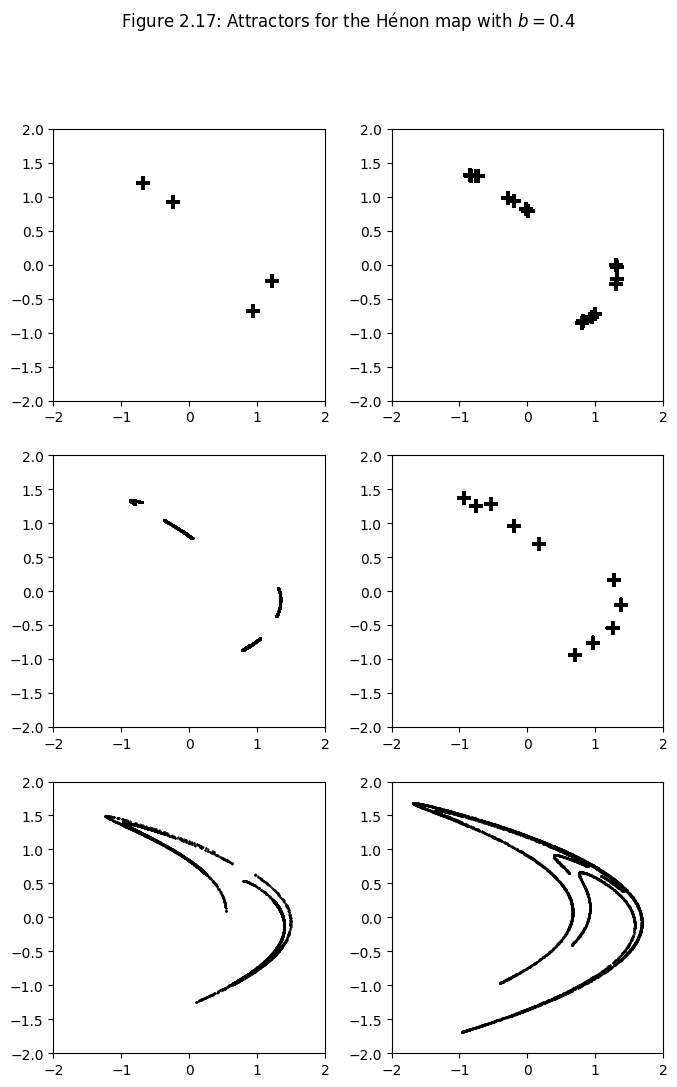

In [26]:
fig, axs = plt.subplots(3, 2, figsize=(8, 12))

a = [0.9, 0.988, 1.0, 1.0293, 1.045, 1.2]
for i in range(6):
    idx = np.unravel_index(i, (3,2))

    plot_henon_attractor(axs[idx], a[i], i in [0,1,3])

fig.suptitle('Figure 2.17: Attractors for the Hénon map with $b = 0.4$')
plt.show()

## Exercício 2

Implementar um mapa de tempo $2 \pi$ para

$$ \theta''(t) = -c \theta'(t) - \sin(\theta(t)) + \rho \cos(t) $$

e reproduzir a Fig. 2.7 do livro.

Escrevendo o sistema como um sistema de EDOs de primeira ordem, temos:

$$ \begin{cases} \theta'(t) = \omega(t) \\ \omega'(t) = -c \omega(t) - \sin(\theta(t)) + \rho \cos(t) \end{cases} $$

In [27]:
# maps an array of angles in radians to the interval [-pi, pi]
def map_pi(x):
    y = x % (2 * np.pi)
    y[y >= np.pi] -= 2 * np.pi
    return y

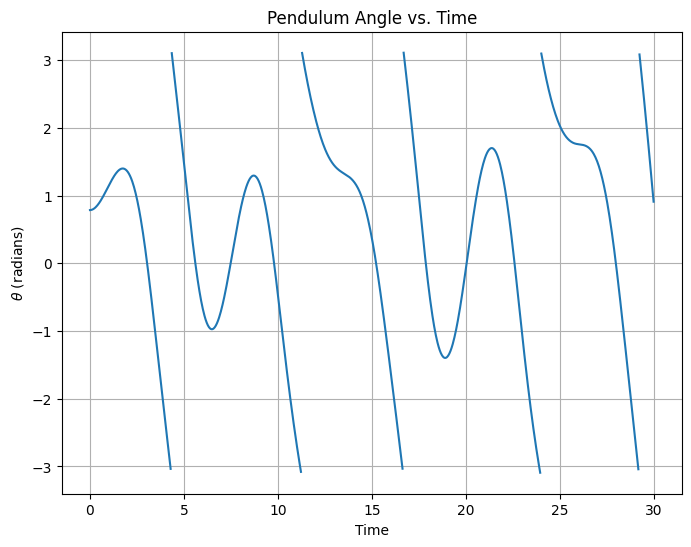

In [38]:
from scipy.integrate import solve_ivp
import matplotlib.cm as cm

c = 0.2
rho = 1.66

# Define the pendulum ODE as a first-order system
def pendulum_ode(t, y):
    theta, omega = y
    theta_dot = omega
    omega_dot = -c * omega - np.sin(theta) + rho * np.cos(t)
    return [theta_dot, omega_dot]

# Set up initial conditions: theta(0) = initial_angle, omega(0) = initial_angular_velocity
initial_angle = np.pi / 4  # 45 degrees
initial_angular_velocity = 0.0
initial_conditions = [initial_angle, initial_angular_velocity]

# Time span for integration
t_span = (0, 30)  
t_eval = np.linspace(0, t_span[1], 1000)

# Solve the IVP using solve_ivp
solution = solve_ivp(pendulum_ode, t_span, initial_conditions, t_eval=t_eval, method='RK45')

# Extract solution
t = solution.t
theta = map_pi(solution.y[0])  # theta in [-pi, pi)
theta_dot = solution.y[1]

# NaN to avoid plotting discontinuities
pos = np.where(np.abs(np.diff(theta)) >= 0.5)[0]
t[pos] = np.nan
theta[pos] = np.nan
theta_dot[pos] = np.nan

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, theta)
plt.xlabel('Time')
plt.ylabel('$\\theta$ (radians)')
plt.title('Pendulum Angle vs. Time')
plt.grid()
plt.show()

In [39]:
from matplotlib.collections import LineCollection
def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)

    cbar = plt.colorbar(lc)
    cbar.set_label('Normalized time')
    
    return lc

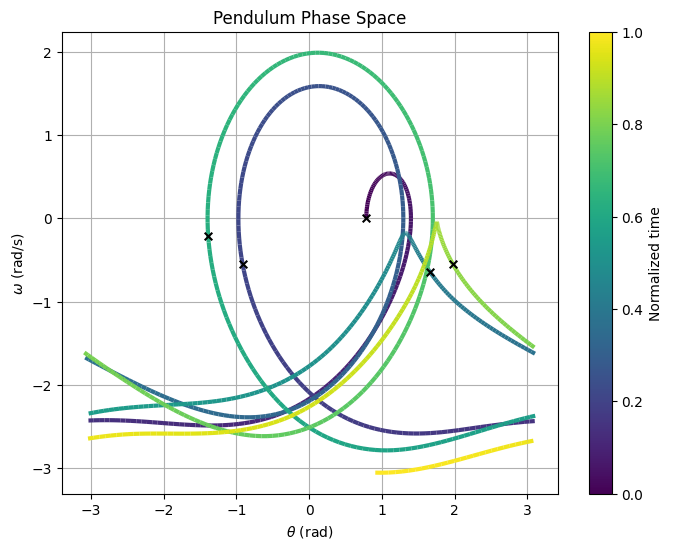

In [40]:
# plot phase space
# x = theta, y = theta_dot

# get discrete time points spaced by 2pi
# by slicing the time array t
# and plot theta, theta_dot at these points
m = int(2*np.pi / (t[-1] - t[0]) * t.size)

normalized_time = t / t[-1]
# filter NaN
normalized_time[pos] = 0.0

fig, ax = plt.subplots(figsize=(8, 6))
colorline(theta, theta_dot, normalized_time, cmap=cm.viridis)
ax.scatter(theta[::m], theta_dot[::m], s=30,c='black',marker='x',zorder=2)
ax.set_xlabel('$\\theta$ (rad)')
ax.set_ylabel('$\\omega$ (rad/s)')
ax.set_title('Pendulum Phase Space')
ax.grid()
plt.show()